In [19]:
## This notebook uses Inception-v3 pretrained model to classify slum patches from satellite imagery patches.

# Part of the code is taken from the  https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/08_Transfer_Learning.ipynb

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import os

import inception

import prettytensor as pt

In [20]:
tf.__version__

'1.7.0'

In [21]:
pt.__version__

'0.7.4'

In [22]:
features = np.load("../final_slum_features_sentinel_4_1826.npy")

print(features[1])

[[[138 129 119]
  [138 129 119]
  [138 129 119]
  ...
  [199 187 170]
  [199 187 170]
  [199 187 170]]

 [[138 129 119]
  [138 129 119]
  [138 129 119]
  ...
  [199 187 170]
  [199 187 170]
  [199 187 170]]

 [[138 129 119]
  [138 129 119]
  [138 129 119]
  ...
  [199 187 170]
  [199 187 170]
  [199 187 170]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [189 190 175]
  [189 190 175]
  [189 190 175]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [189 190 175]
  [189 190 175]
  [189 190 175]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [189 190 175]
  [189 190 175]
  [189 190 175]]]


In [23]:
labels = np.load("../final_slum_labels_sentinel_4_1826.npy")

In [24]:
##one-hot encoding the labels

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)

print(labels)
lables = np.asarray(labels)
labels = labels.reshape(-1,1)

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(labels)
labels = enc.transform(labels).toarray()
print(labels[:10])


[2 2 2 ... 2 1 1]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [25]:
print(labels[1])

[0. 0. 1. 0.]


In [26]:
classes = np.load("../final_slum_labels_sentinel_4_1826.npy")

In [27]:
print(classes[:10])

['s' 's' 's' 's' 's' 'ns' 'w' 'w' 'ns' 's']


In [29]:
cls_orig = np.argmax(labels,axis = 1) 
print(cls_orig)

[2 2 2 ... 2 1 1]


In [31]:
class_names = ['f','ns','s','w']

In [32]:
print(features.shape,labels.shape)

(1826, 128, 128, 3) (1826, 4)


[0. 0. 0. 1.]
w


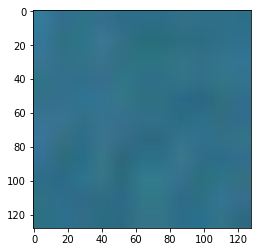

In [33]:
plt.imshow(features[1801])
print(labels[1801])
print(class_names[cls_orig[1801]])
plt.show()

In [34]:
from sklearn.cross_validation import train_test_split

##splitting the data into training and testing set in the ratio 7:3.
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3,random_state=46)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(1278, 128, 128, 3) (1278, 4)
(548, 128, 128, 3) (548, 4)


/home/deepank/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [35]:
images_train = x_train
images_test = x_test
labels_train = y_train
labels_test = y_test

print(labels_test)

cls_train =  np.argmax(labels_train, axis=1)

cls_test = np.argmax(labels_test, axis=1)

print(cls_test[:9],cls_train[:9])

[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
[3 2 2 0 1 2 1 2 1] [1 2 1 2 2 3 2 2 2]


In [36]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		1278
- Test-set:		548


In [37]:
### Helper function to visualize the dataset in 3x3 grid. 

def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

(9, 128, 128, 3)


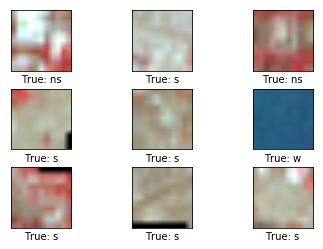

In [38]:
## Visualising the training data

images = images_train[0:9]
print(images.shape)

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

In [39]:
## Downloading the Inception dataset 

inception.data_dir = 'inception/'

In [40]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


In [41]:
##Loading the inception model
model = inception.Inception()

In [42]:
##Helper function to store the transfer values
from inception import transfer_values_cache

In [43]:
data_path = "data_2/CIFAR-10/"   ###set path to store the transfer values
file_path_cache_train = os.path.join(data_path, 'inception_s_ns_train_1826.pkl')
file_path_cache_test = os.path.join(data_path, 'inception_s_ns_test_1826.pkl')
# file_path_cache_new_predict = os.path.join(data_path, 'inception_vhr_new_predict.pkl')  ###use this command to create 
## transfer values for the tiles clipped from complete imagery (prediction set) 

In [44]:
print("Processing Inception transfer-values for training-images ...")

# Scale images because Inception needs pixels to be between 0 and 255 (if required)

transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              images=images_train,
                                              model=model)

Processing Inception transfer-values for training-images ...
- Processing image:   1278 / 1278
- Data saved to cache-file: data_2/CIFAR-10/inception_s_ns_train_1826.pkl


In [45]:
print("Processing Inception transfer-values for test-images ...")

# Scale images because Inception needs pixels to be between 0 and 255 (if required)

transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             images=images_test,
                                             model=model)

Processing Inception transfer-values for test-images ...
- Processing image:    548 / 548
- Data saved to cache-file: data_2/CIFAR-10/inception_s_ns_test_1826.pkl


In [46]:
transfer_values_train.shape

(1278, 2048)

In [47]:
transfer_values_test.shape

(548, 2048)

In [48]:
##Helper function to plot transfer values

def plot_transfer_values(i):
    print("Input image:")
    
    # Plot the i'th image from the test-set.
    plt.imshow(images_test[i], interpolation='nearest')
    plt.show()

    print("Transfer-values for the image using Inception model:")
    
    # Transform the transfer-values into an image.
    img = transfer_values_test[i]
    print(img)
    img = img.reshape((32, 64))

    # Plot the image for the transfer-values.
    plt.imshow(img, interpolation='nearest', cmap='Greys')
    plt.show()

Input image:


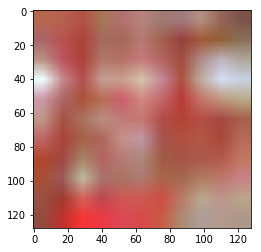

Transfer-values for the image using Inception model:
[0.10186286 0.07320684 0.08805446 ... 0.38432255 0.01097476 0.6138909 ]


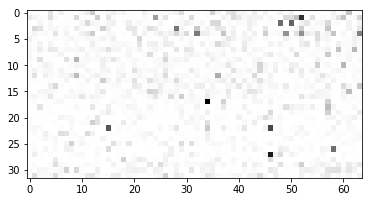

In [49]:
plot_transfer_values(i=20)

Input image:


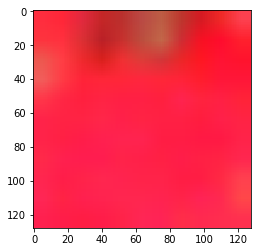

Transfer-values for the image using Inception model:
[0.2541843  0.07458189 0.03285344 ... 0.5684732  0.26289174 0.59840715]


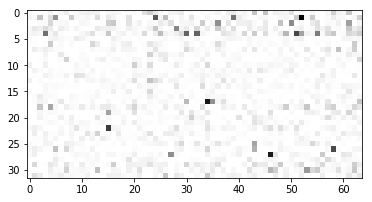

In [50]:
plot_transfer_values(i=315)

In [69]:
##Using PCA to plot transfer values in two dimensions

from sklearn.decomposition import PCA

In [70]:
pca = PCA(n_components=2)

In [71]:
transfer_values = transfer_values_train

In [72]:
cls = cls_train
print(cls)

[1 2 1 ... 1 2 3]


In [73]:
transfer_values.shape

(1278, 2048)

In [74]:
transfer_values_reduced = pca.fit_transform(transfer_values)

In [75]:
transfer_values_reduced.shape

(1278, 2)

In [76]:
## Helper function to plot reduced transfer values

def plot_scatter(values, cls):
    # Create a color-map with a different color for each class.
    import matplotlib.cm as cm
    num_classes = 4
    cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes))
#     print(cmap)
    # Get the color for each sample.
    colors = cmap[cls]
#     print(colors[:,2][900:1000])
    # Extract the x- and y-values.
    x = values[:, 0]
    y = values[:, 1]

    # Plot it.
    plt.figure(figsize=(7.5,7.5))
    plt.scatter(x, y, color=colors, marker = "o")
    plt.grid()
    plt.savefig("pca_mr.jpg")
    plt.show()

(1278,)


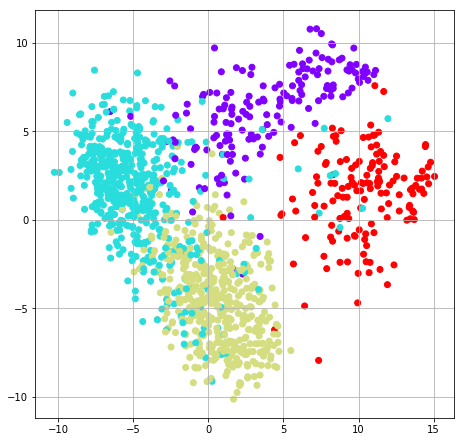

In [77]:
print(cls.shape)
plot_scatter(transfer_values_reduced, cls)

In [61]:
## Using t-sne to plot transfer values in two dimensions

from sklearn.manifold import TSNE

In [62]:
## Reducing 2048 Values to 50 using PCA 
pca = PCA(n_components=50)
transfer_values_50d = pca.fit_transform(transfer_values)

In [63]:
tsne = TSNE(n_components=2)

In [64]:
transfer_values_reduced = tsne.fit_transform(transfer_values_50d) 

In [65]:
transfer_values_reduced.shape

(1278, 2)

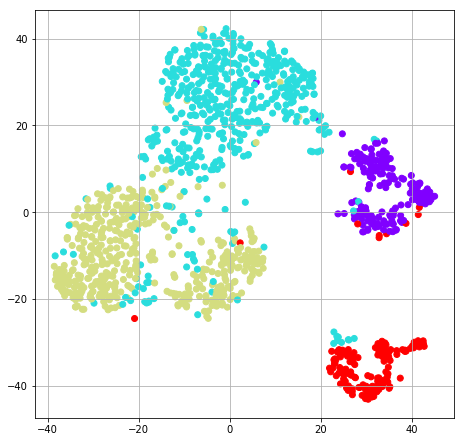

In [66]:
plot_scatter(transfer_values_reduced, cls)

In [47]:
## Creating Neural Network classifier

## First we need the array-length for transfer-values which is stored as a variable in the object for the Inception model.
transfer_len = model.transfer_len
print(transfer_len)

2048


In [48]:
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')

In [49]:
num_classes = 4
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [50]:
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


In [51]:
# Wrap the transfer-values as a Pretty Tensor object.
x_pretty = pt.wrap(x)

with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        fully_connected(size=1024, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [52]:
## Create a variable for keeping track of the number of optimization iterations performed.
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

In [53]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)

In [54]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [55]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [56]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [57]:
## Creating tensorflow session
session = tf.Session()

In [58]:
session.run(tf.global_variables_initializer())

In [59]:
train_batch_size = 16

In [60]:
## function for feeding random batch of transfer values in the model

def random_batch():
    # Number of images (transfer-values) in the training-set.
    num_images = len(transfer_values_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random x and y-values.
    # We use the transfer-values instead of images as x-values.
    x_batch = transfer_values_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch

In [61]:
## Helper function to perform optimization

def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images (transfer-values) and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [62]:
## Helper functions for showing results 

def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]

    n = min(9, len(images))
    
    # Plot the first n images.
    plot_images(images=images[0:n],
                cls_true=cls_true[0:n],
                cls_pred=cls_pred[0:n])

In [63]:
## Helper function to plot confusion matrix
## Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))
    
    np.savetxt('confusion_matrix.txt', cm, fmt='%3.0f',delimiter=',')

In [64]:
# Helper functions for calculating classifications

# Split the data-set in batches of this size to limit RAM usage.
batch_size = 16

def predict_cls(transfer_values, labels, cls_true):
    # Number of images.
    num_images = len(transfer_values)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: transfer_values[i:j],
                     y_true: labels[i:j]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
        
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

In [65]:
## Calculate the predicted class for the test-set.
def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test,
                       labels = labels_test,
                       cls_true = cls_test)

In [66]:
## helper function for calculating the classification accuracy
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.

    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

In [67]:
## helper function for showing classification accuracy

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [68]:
#performance before any optimization

print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=False)

Accuracy on Test-Set: 35.4% (194 / 548)


In [69]:
## performance after 20000 optimization iterations
optimize(num_iterations=20000)

Global Step:    100, Training Batch Accuracy: 100.0%
Global Step:    200, Training Batch Accuracy: 100.0%
Global Step:    300, Training Batch Accuracy: 100.0%
Global Step:    400, Training Batch Accuracy: 100.0%
Global Step:    500, Training Batch Accuracy: 100.0%
Global Step:    600, Training Batch Accuracy: 100.0%
Global Step:    700, Training Batch Accuracy: 100.0%
Global Step:    800, Training Batch Accuracy: 100.0%
Global Step:    900, Training Batch Accuracy: 100.0%
Global Step:   1000, Training Batch Accuracy: 100.0%
Global Step:   1100, Training Batch Accuracy: 100.0%
Global Step:   1200, Training Batch Accuracy:  93.8%
Global Step:   1300, Training Batch Accuracy: 100.0%
Global Step:   1400, Training Batch Accuracy: 100.0%
Global Step:   1500, Training Batch Accuracy: 100.0%
Global Step:   1600, Training Batch Accuracy: 100.0%
Global Step:   1700, Training Batch Accuracy: 100.0%
Global Step:   1800, Training Batch Accuracy: 100.0%
Global Step:   1900, Training Batch Accuracy: 

Accuracy on Test-Set: 97.4% (534 / 548)
Example errors:


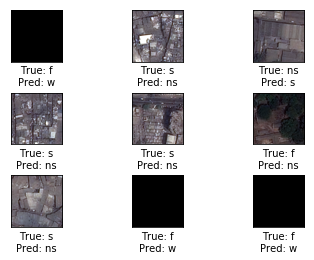

Confusion Matrix:
[63  3  0  5] (0) f
[  0 215   2   0] (1) ns
[  0   4 195   0] (2) s
[ 0  0  0 61] (3) w
 (0) (1) (2) (3)


In [70]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

In [71]:
##new_prediction

In [90]:
### Obtain the transfer values for prediction dataset

print("Processing Inception transfer-values for test-images ...")

images_new_predict = np.load("/media/deepank/086C617F6C616880/extra_space/vhr_clip_177x177/mum4_map_prep_pleiades.npy", mmap_mode= 'r')
file_path_cache_new_predict = os.path.join(data_path, 'mum4_map_prep_pleiades_predict.pkl')

transfer_values_new_predict = transfer_values_cache(cache_path=file_path_cache_new_predict,
                                             images=images_new_predict,
                                             model=model)

Processing Inception transfer-values for test-images ...
- Processing image:  89198 / 89198
- Data saved to cache-file: vhr_save/mum4_map_prep_pleiades_predict.pkl


In [91]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 16

def predict_cls_1(transfer_values):
    # Number of images.
    num_images = len(transfer_values)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: transfer_values[i:j]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
        
    # Create a boolean array whether each image is correctly classified.
#     correct = (cls_true == cls_pred)

    return cls_pred

In [92]:
def predict_cls_new():
    return predict_cls_1(transfer_values = transfer_values_new_predict)


In [93]:
predict_cls_new()[:20]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

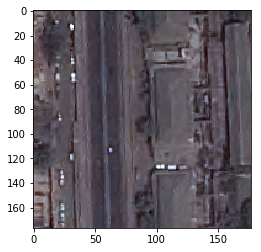

In [94]:
plt.imshow(images_new_predict[2013])

In [95]:
## save the predictions
np.save("/media/deepank/086C617F6C616880/extra_space/vhr_clip_177x177/mum4_map_prep_pleiades_predictions", predict_cls_new())   

In [73]:
## close tensorflow session
model.close()
session.close()